# CNN + GlobalAvgPool 
Based on CNN 107 which got 75% acc on H1 coding len 2000-4000.  
Model: Embed mask, Conv1D, GlobalAvgPool.   

H1 coding len 3000-4000.  
Cross validation 5 folds 5 epochs, accuracy mean , F1 mean 

Same as CNN 118 but switch cell line 1 to 9.   


In [263]:
from datetime import datetime
print(datetime.now())
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

2022-12-29 16:38:58.803000
Python 3.8.16
sklearn 1.0.2


We prevously used sklearn.model_selection.ShuffleSplit   
Now we avoid it due to this note in the 
[documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html):
Note: contrary to other cross-validation strategies, random splits do not guarantee that all folds will be different, although this is still very likely for sizeable datasets.

In [264]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
tf.random.set_seed(42) 

from tensorflow import keras
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import Flatten
from keras.layers import Attention
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=4
RCI_THRESHOLD=0.0
CFILTERS=64
FILTERSIZE=8
RCELLS=16
DCELLS=8
EPOCHS=5
FOLDS=5      
EMBED_DIMEN = 4 # arbitrary hyperparameter
BREAK = False   # break after first fold
MINLEN=3000
MAXLEN=4000   

In [265]:
try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/'    # Mac
print(DATA_DIR)

Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/


In [266]:
GENES_FILE =    'CNRCI_coding_train_genes.csv'
RCI_FILE =      'CNRCI_coding_train_RCI.gc42.csv'
SEQUENCE_FILE = 'CNRCI_coding_train_transcripts.gc42.csv'
COUNTS_FILE=    'CNRCI_coding_train_counts.K4.gc42.csv'

In [267]:
def get_ordered_list():
    ordered_list = \
    ['A549',\
      'H1.hESC',\
      'HeLa.S3',\
      'HepG2',\
      'HT1080',\
      'HUVEC',\
      'MCF.7',\
      'NCI.H460',\
      'NHEK',\
      'SK.MEL.5',\
      'SK.N.DZ',\
      'SK.N.SH',\
      'GM12878',\
      'K562',\
      'IMR.90']
    return ordered_list
CELL_LINE_NUMBER=9

all_cell_lines = get_ordered_list()
cell_line_name = all_cell_lines[CELL_LINE_NUMBER]
print('Cell line for today:',CELL_LINE_NUMBER,'=',cell_line_name)

Cell line for today: 9 = SK.MEL.5


## Data Load

In [268]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        
    def load_gene_rci_values(self,filepath,cell_line):
        '''
        Load from RCI csv file.
        Return dict with keys=gene:str and values=RCI:float.
        '''
        gene_to_rci = {}
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields[0]
                    rci_val = fields[cell_line+1]
                    if rci_val != "nan":
                        # Convert string nan to float(nan)
                        gene_to_rci[gene_id] = float(rci_val)
        return gene_to_rci
    
    def seq_to_kmer_values(self,rna,K):
        # The cache may represent more than one K. Probably not a problem.
        N_indicator = 0 # indicator value
        vec=[] # seq converted to list of K-mers 
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def rci_to_label(self,rci):
        CYTO_LABEL = 1
        NUCLEAR_LABEL = 0
        # cnrci = log (cyto-to-nuclear ratio)
        # rci > 0 implies cytoplasmic
        if rci > RCI_THRESHOLD:
            return CYTO_LABEL
        return NUCLEAR_LABEL

    def load_sequence(self,filepath):
        labels=[]
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # with version number
                    gene_id = fields[1]        # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    if seq_len>=MINLEN and seq_len<=MAXLEN and gene_id in gene_to_rci.keys():
                        allids.append( (gene_id,tran_id) )
                        rci_val = gene_to_rci[gene_id]
                        rci_label = self.rci_to_label(rci_val)
                        labels.append(rci_label)
                        if seq_len<MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                            seq_txt = seq_txt[:MAXLEN]
                        hot_vec = self.seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        return labels,allids,allseq
    
loader = DataLoader()
# test it
print(loader.seq_to_kmer_values('AAAA',3))
print(loader.seq_to_kmer_values('CATT',3))
print(loader.seq_to_kmer_values('TTGA',3))
print(loader.seq_to_kmer_values('TTTN',3))
# test it
print(loader.rci_to_label(-0.9))
print(loader.rci_to_label(1.1))

[1, 1]
[20, 16]
[63, 57]
[64, 0]
0
1


In [269]:
print(datetime.now())
print("Load RCI values...")
loader = DataLoader()
filepath = DATA_DIR+RCI_FILE
gene_to_rci = loader.load_gene_rci_values(filepath,CELL_LINE_NUMBER)
print('Num RCI:', len(gene_to_rci.keys()))
print('Example RCI:', list(gene_to_rci.items())[:3])
print("Load genes...")
all_genes = list(gene_to_rci.keys())
print(datetime.now())
print('Load sequence...')
filepath = DATA_DIR+SEQUENCE_FILE
labels,allids,allseq = loader.load_sequence(filepath)
print(datetime.now())
print('Num IDs:',len(allids))
print('Example IDs:',[allids[x] for x in [10, 20, 30, 40]] )
print('Count',np.count_nonzero(labels),'ones out of',len(labels),'labels.')
print('Example labels:',[labels[x] for x in [10, 20, 30, 40]] )
print('Num counts:',len(allseq))
print('Example sequence:',allseq[3])
loader = None  # drop K-mer cache to save RAM

2022-12-29 16:39:01.305830
Load RCI values...
Num RCI: 8407
Example RCI: [('ENSG00000000003', 1.83753), ('ENSG00000000419', 0.364575), ('ENSG00000000460', -2.34965)]
Load genes...
2022-12-29 16:39:01.334908
Load sequence...
2022-12-29 16:39:09.418968
Num IDs: 4941
Example IDs: [('ENSG00000008130', 'ENST00000341426.9'), ('ENSG00000171680', 'ENST00000535355.6'), ('ENSG00000171680', 'ENST00000537245.6'), ('ENSG00000116688', 'ENST00000675298.1')]
Count 2300 ones out of 4941 labels.
Example labels: [0, 0, 0, 1]
Num counts: 4941
Example sequence: [33, 131, 10, 38, 151, 89, 97, 131, 11, 43, 171, 169, 163, 140, 46, 183, 219, 106, 167, 155, 106, 165, 146, 69, 17, 65, 1, 4, 15, 59, 234, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 167, 155, 106, 168, 159, 123, 236, 175, 186, 232, 159, 122, 229, 147, 75, 43, 172, 174, 183, 219, 106, 165, 147, 74, 40, 158, 118, 214, 87, 90, 103, 155, 106, 165, 147, 74, 39, 155, 106, 166, 151, 91, 106, 167, 154, 102, 150, 86, 87, 91, 1

## Model

In [270]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    rnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    #rnn1_layer = Bidirectional( LSTM(RCELLS, return_sequences=False) )
    #pool_layer = MaxPooling1D(pool_size=3)
    pool_layer = GlobalAveragePooling1D()
    #pool_layer = GlobalMaxPooling1D()
    flat_layer = Flatten()
    den1_layer = Dense(DCELLS)
    drop_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    rnn.add(embed_layer)
    rnn.add(cnn1_layer)
    rnn.add(pool_layer)
    #rnn.add(flat_layer)
    #rnn.add(den1_layer)
    #rnn.add(drop_layer)
    rnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    print("COMPILE")
    rnn.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return rnn

In [271]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once

2022-12-29 16:39:09.450533
COMPILE
Model: "sequential_136"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_136 (Embedding)   (None, 3997, 4)           1028      
                                                                 
 conv1d_136 (Conv1D)         (None, 3990, 64)          2112      
                                                                 
 global_average_pooling1d_12  (None, 64)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_271 (Dense)           (None, 1)                 65        
                                                                 
Total params: 3,205
Trainable params: 3,205
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [272]:
class CrossValidator():
    def __init__(self,epochs,folds,quick_test=False,pred_threshold=0.5):
        self.epochs = epochs
        self.folds = folds
        self.quick_test = quick_test
        self.threshold = pred_threshold # e.g. score>0.5 => class 1
    
    def get_gene_subset(self,all_genes,sub_index):
        sub_genes = set()
        for index in sub_index:
            one_gene = all_genes[index]
            sub_genes.add(one_gene)
        return sub_genes
    
    def get_X_y(self,gene_set,allids,allX,allY):
        cnt = len(allids)
        subsetX=[]
        subsetY=[]
        if cnt != len(allX) or cnt!= len(allY):
            raise Exception('Lengths differ')
        for i in range(cnt):
            gene_id,tran_id = allids[i]
            if gene_id in gene_set:
                oneX = allX[i]
                oneY = allY[i]
                subsetX.append(oneX)
                subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def do_cross_validation(self):
        cv_accuracy=[]
        cv_precision=[]
        cv_recall=[]
        cv_f1=[]
        fold=0
        print(datetime.now())
        print('splitting')
        # KFold shuffles once before making the partitions
        splitter = KFold(n_splits=self.folds,shuffle=True,random_state=42)
        for train_index,valid_index in splitter.split(all_genes):
            fold += 1
            print('Fold',fold)
            train_genes = self.get_gene_subset(all_genes,train_index)
            valid_genes = self.get_gene_subset(all_genes,valid_index)
            X_train,y_train = self.get_X_y(train_genes,allids,allseq,labels)
            X_valid,y_valid = self.get_X_y(valid_genes,allids,allseq,labels)

            print('Training example')
            print(X_train[0])

            print('Train sizes',X_train.shape,y_train.shape)
            print('Valid sizes',X_valid.shape,y_valid.shape)
            print('Train set ones/size',
                  np.count_nonzero(y_train),'/',len(y_train))
            print('Valid set ones/size',
                  np.count_nonzero(y_valid),'/',len(y_valid))

            print("BUILD MODEL")
            model=build_model()

            print("FIT")
            print(datetime.now())
            history=model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
                    epochs=self.epochs, verbose=1,  # verbose=1 for ascii art, verbose=0 for none
                    validation_data=(X_valid,y_valid) )

            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()

            print("Compute valiation accuracy")
            print(datetime.now())
            yhat_pred=model.predict(X_valid, verbose=0) 
            print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
            yhat_classes=np.where(yhat_pred > self.threshold, 1, 0)
            print('Predicted zeros and ones',np.count_nonzero(yhat_classes==0),np.count_nonzero(yhat_classes==1))
            # accuracy: (tp + tn) / (p + n)
            accuracy = accuracy_score(y_valid, yhat_classes)*100.
            # precision tp / (tp + fp)
            precision = precision_score(y_valid, yhat_classes)*100.
            # recall: tp / (tp + fn)
            recall = recall_score(y_valid, yhat_classes)*100.
            # f1: 2 tp / (2 tp + fp + fn)
            f1 = f1_score(y_valid, yhat_classes)*100.
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%% F1: %.2f%%' % (accuracy,precision,recall,f1)) 
            print(datetime.now())
            cv_accuracy.append(accuracy)
            cv_precision.append(precision)
            cv_recall.append(recall)
            cv_f1.append(f1)
            if self.quick_test:   
                print('Break -- this was for code testing only')
                break
        print()
        return cv_accuracy, cv_precision, cv_recall, cv_f1

2022-12-29 16:39:09.609410
2022-12-29 16:39:09.609582
splitting
Fold 1
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3917, 3997) (3917, 1)
Valid sizes (1024, 3997) (1024, 1)
Train set ones/size 1815 / 3917
Valid set ones/size 485 / 1024
BUILD MODEL
COMPILE
FIT
2022-12-29 16:39:10.969309
Epoch 1/5
123/123 [==============================] - 2s 9ms/step - loss: 0.6906 - accuracy: 0.5336 - val_loss: 0.6903 - val_accuracy: 0.5264
Epoch 2/5
123/123 [==============================] - 1s 8ms/step - loss: 0.6865 - accuracy: 0.5366 - val_loss: 0.6848 - val_accuracy: 0.5586
Epoch 3/5
123/123 [==============================] - 1s 7ms/step - loss: 0.6811 - accuracy: 0.5632 - val_loss: 0.6788 - val_accuracy: 0.5781
Epoch 4/5
123/123 [==============================] - 1s 7ms/step - loss: 0.6714 - accuracy: 0.5839 - val_loss: 0.6737 - val_accuracy: 0.5977
Epoch 5/5
123/123 [==============================] - 1s 7ms/step - loss: 0.6624 - accuracy: 0.6012 - val_loss: 0.6727 - val_accuracy: 

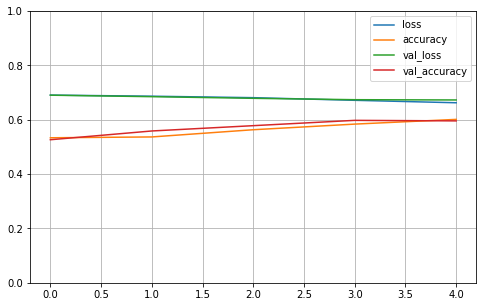

Compute valiation accuracy
2022-12-29 16:39:16.456822
Range of scores: 0.17847167 to 0.7828677
Predicted zeros and ones 583 441
Accuracy: 59.57% Precision: 58.05% Recall: 52.78% F1: 55.29%
2022-12-29 16:39:16.692704
Fold 2
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3849, 3997) (3849, 1)
Valid sizes (1092, 3997) (1092, 1)
Train set ones/size 1787 / 3849
Valid set ones/size 513 / 1092
BUILD MODEL
COMPILE
FIT
2022-12-29 16:39:17.877402
Epoch 1/5
121/121 [==============================] - 2s 9ms/step - loss: 0.6909 - accuracy: 0.5362 - val_loss: 0.6897 - val_accuracy: 0.5302
Epoch 2/5
121/121 [==============================] - 1s 7ms/step - loss: 0.6868 - accuracy: 0.5443 - val_loss: 0.6851 - val_accuracy: 0.5321
Epoch 3/5
121/121 [==============================] - 1s 8ms/step - loss: 0.6798 - accuracy: 0.5747 - val_loss: 0.6842 - val_accuracy: 0.5440
Epoch 4/5
121/121 [==============================] - 1s 7ms/step - loss: 0.6721 - accuracy: 0.5796 - val_loss: 0.6818 - val

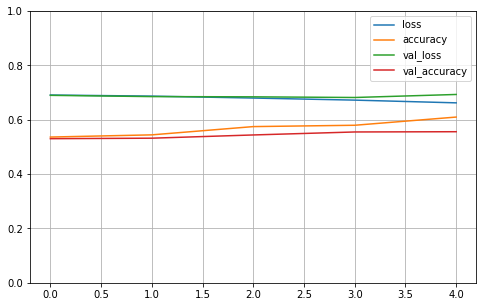

Compute valiation accuracy
2022-12-29 16:39:23.805677
Range of scores: 0.09378984 to 0.7039687
Predicted zeros and ones 930 162
Accuracy: 55.59% Precision: 58.64% Recall: 18.52% F1: 28.15%
2022-12-29 16:39:24.001280
Fold 3
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (4004, 3997) (4004, 1)
Valid sizes (937, 3997) (937, 1)
Train set ones/size 1870 / 4004
Valid set ones/size 430 / 937
BUILD MODEL
COMPILE
FIT
2022-12-29 16:39:25.179347
Epoch 1/5
126/126 [==============================] - 2s 9ms/step - loss: 0.6900 - accuracy: 0.5355 - val_loss: 0.6876 - val_accuracy: 0.5390
Epoch 2/5
126/126 [==============================] - 1s 7ms/step - loss: 0.6853 - accuracy: 0.5500 - val_loss: 0.6819 - val_accuracy: 0.5539
Epoch 3/5
126/126 [==============================] - 1s 7ms/step - loss: 0.6780 - accuracy: 0.5704 - val_loss: 0.6786 - val_accuracy: 0.5582
Epoch 4/5
126/126 [==============================] - 1s 7ms/step - loss: 0.6696 - accuracy: 0.5899 - val_loss: 0.6791 - val_ac

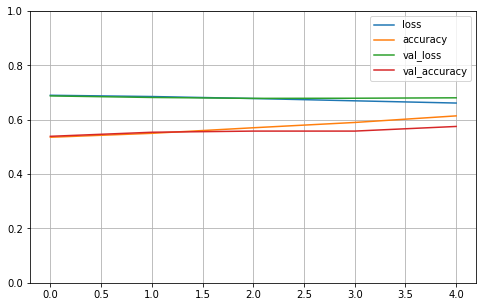

Compute valiation accuracy
2022-12-29 16:39:31.055481
Range of scores: 0.1761965 to 0.793747
Predicted zeros and ones 623 314
Accuracy: 57.52% Precision: 55.10% Recall: 40.23% F1: 46.51%
2022-12-29 16:39:31.304670
Fold 4
Training example
[ 95 123 235 ...   0   0   0]
Train sizes (3946, 3997) (3946, 1)
Valid sizes (995, 3997) (995, 1)
Train set ones/size 1875 / 3946
Valid set ones/size 425 / 995
BUILD MODEL
COMPILE
FIT
2022-12-29 16:39:32.491803
Epoch 1/5
124/124 [==============================] - 2s 9ms/step - loss: 0.6916 - accuracy: 0.5193 - val_loss: 0.6843 - val_accuracy: 0.5739
Epoch 2/5
124/124 [==============================] - 1s 7ms/step - loss: 0.6854 - accuracy: 0.5428 - val_loss: 0.6844 - val_accuracy: 0.5397
Epoch 3/5
124/124 [==============================] - 1s 7ms/step - loss: 0.6773 - accuracy: 0.5730 - val_loss: 0.6818 - val_accuracy: 0.5628
Epoch 4/5
124/124 [==============================] - 1s 7ms/step - loss: 0.6706 - accuracy: 0.5960 - val_loss: 0.6727 - val_accu

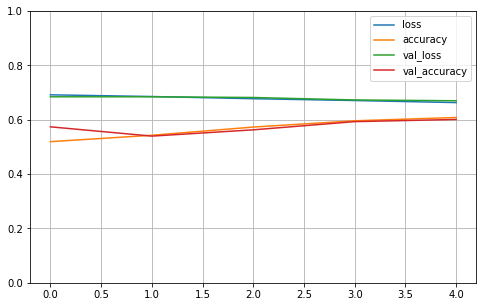

Compute valiation accuracy
2022-12-29 16:39:37.965712
Range of scores: 0.1535288 to 0.77506435
Predicted zeros and ones 593 402
Accuracy: 60.10% Precision: 53.48% Recall: 50.59% F1: 52.00%
2022-12-29 16:39:38.212783
Fold 5
Training example
[ 62 246 215 ...   0   0   0]
Train sizes (4048, 3997) (4048, 1)
Valid sizes (893, 3997) (893, 1)
Train set ones/size 1853 / 4048
Valid set ones/size 447 / 893
BUILD MODEL
COMPILE
FIT
2022-12-29 16:39:39.388976
Epoch 1/5
127/127 [==============================] - 2s 9ms/step - loss: 0.6893 - accuracy: 0.5422 - val_loss: 0.6972 - val_accuracy: 0.4994
Epoch 2/5
127/127 [==============================] - 1s 7ms/step - loss: 0.6849 - accuracy: 0.5477 - val_loss: 0.6890 - val_accuracy: 0.5677
Epoch 3/5
127/127 [==============================] - 1s 7ms/step - loss: 0.6813 - accuracy: 0.5618 - val_loss: 0.6899 - val_accuracy: 0.5622
Epoch 4/5
127/127 [==============================] - 1s 7ms/step - loss: 0.6764 - accuracy: 0.5677 - val_loss: 0.6762 - val_ac

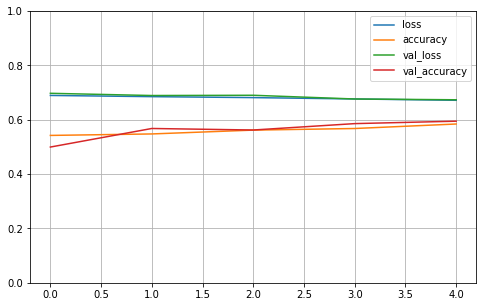

Compute valiation accuracy
2022-12-29 16:39:44.983882
Range of scores: 0.21230958 to 0.6339432
Predicted zeros and ones 686 207
Accuracy: 59.46% Precision: 70.53% Recall: 32.66% F1: 44.65%
2022-12-29 16:39:45.173486

Cross validation 5 folds 5 epochs
 accuracy mean 58.45% +/- 1.68
 precision mean 59.16% +/- 5.99
 recall mean 38.96% +/- 12.53
 F1 mean 45.32% +/- 9.39
2022-12-29 16:39:45.176304


In [273]:
print(datetime.now())
cvdo = CrossValidator(EPOCHS,FOLDS,BREAK)
cv_accuracy, cv_precision, cv_recall, cv_f1 = cvdo.do_cross_validation()   
print("Cross validation %d folds %d epochs" % (FOLDS,EPOCHS)) 
print(" accuracy mean %.2f%% +/- %.2f" % (np.mean(cv_accuracy), np.std(cv_accuracy)))
print(" precision mean %.2f%% +/- %.2f" % (np.mean(cv_precision), np.std(cv_precision)))
print(" recall mean %.2f%% +/- %.2f" % (np.mean(cv_recall), np.std(cv_recall)))
print(" F1 mean %.2f%% +/- %.2f" % (np.mean(cv_f1), np.std(cv_f1)))
print(datetime.now())